In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot') # prevent border around the plot

In [2]:
import dataframe_image as dfi
import os

In [3]:
from IPython.display import display
p = print
d = display
def val(x):
  if (isinstance(x, (int, np.integer)) or isinstance(x, (float, np.float))) and not isinstance(x, (bool, np.bool)):
    return x
  try:
    return int(x) if not x is None else 0
  except ValueError:
    try:
      return float(x)
    except ValueError:
      return 0

In [5]:
def disp_to_file(df, path, sub_fname=''):
  path_ = f'{path}{sub_fname}.png'
  page = 0
  while page * 28 < len(df):
    #p(path_)
    df_ = df.iloc[28 * page:28 * (page + 1),]
    with open(path_, "w") as f:
      df_styled = df_.style
      dfi.export(df_styled, path_)
    os.startfile(path_, "print")
    page += 1
    path_ = f'{path}_{page}{sub_fname}.png'
  
#disp_to_file(df_sol, fname, '_solution')    

In [110]:
def getPos(df, values):
  pos=[]
  rows = df.loc[df.isin(values).any(axis=1)].index.to_list()
  cols = df.loc[df.isin(values).any(axis=0)].index.to_list()
  for r in rows:
    for c in cols:
      for v in values:
        if df.loc[r, c]==v:
          pos.append((r, c))
  return pos
#getPos(hashi, [3,4])

# Modify Hashi

In [107]:
DEBUG = False
fname_ = 'hashi'
df_sol = None
lists = {}

nodes = {}
roads = {}
def make_nodes(hashi):
  n = -1
  for i in range(rows):
    node = None
    for j in range(cols):
      n += 1
      nodes[n] = (i,j)
      nodes[(i,j)] = n
      if hashi.iloc[i,j] == 0:
        continue
      if node is None:
        node = n
        node_val = hashi.iloc[i,j]
        continue
      if not (node_val == 1 and hashi.iloc[i,j] == 1):
        min_ = 2
        if (node_val == 2 and hashi.iloc[i,j] == 2):
          min_ = 1
        roads[node, n] = min(node_val, min(min_, hashi.iloc[i,j]))
      node = n
      node_val = hashi.iloc[i,j]
  # now the columns connections
  for j in range(cols):
    node = None
    for i in range(rows):
      n = i * cols + j
      if hashi.iloc[i,j] == 0:
        continue
      if node is None:
        node = n
        node_val = hashi.iloc[i,j]
        continue
      if not (node_val == 1 and hashi.iloc[i,j] == 1):
        min_ = 2
        if (node_val == 2 and hashi.iloc[i,j] == 2):
          min_ = 1
        roads[node, n] = min(node_val, min(min_, hashi.iloc[i,j]))
      node = n
      node_val = hashi.iloc[i,j]
  if DEBUG:
    p('Nodes:', nodes)
    p('\nRoads:\n')
    p(roads)
#make_nodes(hashi)  

In [12]:
from copy import deepcopy

links_org = None
def make_links():
  links = {}
  for x, y in roads.keys():
      if x in links:
          links[x].append(y)
      else:
          links[x] = [y]
      if y in links:
          links[y].append(x)
      else:
          links[y] = [x]
  if DEBUG: p(links)
  links_org = deepcopy(links)
  return links, links_org

## Plot

In [13]:
def plot_table(df):
    if DEBUG: p('In plot_table')
    
    fig, ax = plt.subplots(dpi=144)
    ax.set_facecolor('w')  # white background

    df_ = df.T
    rows = len(df_)
    cols = len(df_.columns)
    plt.xlim(-1, rows)
    plt.ylim(cols, -1)

      # remover borders
  #  ax.spines["top"].set_visible(False)
  #  ax.spines["right"].set_visible(False)
  #  ax.spines["left"].set_visible(False)
  #  ax.spines["bottom"].set_visible(False)

    for i in range(rows):
      for j in range(cols):
        if val(df_.iloc[i,j]) == 0:
          continue
        ax.text(i, j, df_.iloc[i, j], 
           ha="center", va="center",
           bbox=dict(boxstyle="circle", facecolor='white', alpha=1, edgecolor='black')
           )
    png_path = f'{fname}_table.png'
    plt.savefig(png_path)
    plt.show()

    os.startfile(png_path, "print")  
#plot_table(h_fix) 

In [14]:
import matplotlib.transforms as transforms
def plot_trip(l):
  l_ = {}
  if DEBUG: p('in plot_trip', len(l.keys()), l)
  fig, ax = plt.subplots(dpi=144)
  ax.set_facecolor('w')
  plt.xlim(-1, rows)
  plt.ylim(cols, -1)

  for tup, n_conn in l.items():
    new_tup = (tup[1], tup[0])
    if new_tup in l_:  # skip duplicates
      continue
    l_[new_tup] = 0
    p1 = nodes[tup[0]]
    p2 = nodes[tup[1]]
    df = pd.DataFrame([p1, p2], index=['p1', 'p2'])
    line, = ax.plot(df[1], df[0], lw=1, color='black')#, lw= 2 * (lw * 2 - 1))

    ax.text(p1[1], p1[0], hashi.iloc[p1[0], p1[1]], 
         ha="center", va="center",
         bbox=dict(boxstyle="circle", facecolor='white', alpha=1, edgecolor='black')
         ) 
    
    if n_conn == 1:
      continue
    # shift the lines over 2 points
    # from site: https://matplotlib.org/2.0.2/users/transforms_tutorial.html
    dx = df[1][0] - df[1][1]
    dy = df[0][0] - df[0][1]
    if dx != 0:
      dy = 2/72
      dx = 0
    else:
      dy = 0
      dx = 2/72
    offset = transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    shadow_transform = ax.transData + offset

      # now plot the same data with our offset transform;
      # use the zorder to make sure we are below the line
    ax.plot(df[1], df[0], lw=1, color='black', transform=shadow_transform,  zorder=0.5*line.get_zorder())

  png_path = fname + '_plot.png'
  plt.savefig(png_path)
  plt.show()

  os.startfile(png_path, "print")  
#plot_trip(l)  

# DO the trip

In [15]:
class Node:
    def __init__(self, data):
        self.data = data
        self.next = None
        
class Stack:
    def __init__(self):
        self.head = None
 
    def push(self, data):
        if DEBUG: p('push', data)
        if self.head is None:
            self.head = Node(data)
        else:
            new_node = Node(data)
            new_node.next = self.head
            self.head = new_node
 
    def pop(self):
        if self.head is None:
            return None
        else:
            popped = self.head.data
            tmp = self.head.next
            del self.head
            self.head = tmp
            if DEBUG: p('pop', popped)
            return popped

In [16]:
queue = Stack()

def find_city(h):
       # try a city in the list which has connections left
    if DEBUG: p('in find city')
    for i in range(rows * cols):
      if val(h.iloc[nodes[i]]) > 0:
        if DEBUG: p('found city', i)
        return i
      
def is_road_blocked(h, tup, block=['-', '/', 'X']):
    node1, node2 = nodes[tup[0]], nodes[tup[1]]
    rows=[node1[0], node2[0]]
    cols=[node1[1], node2[1]]
    if rows[0] > rows[1]:
      rows[0], rows[1] = rows[1], rows[0]
    if cols[0] > cols[1]:
      cols[0], cols[1] = cols[1], cols[0]
    for r in range(rows[0], rows[1] + 1):
      for c in range(cols[0], cols[1] + 1):
#        if (tup[0] == 60 or tup[1] == 60): p('in is_road_blocked', tup, node1, node2, rows, cols, block, r, c, h.iloc[r, c])
        if h.iloc[r, c] in block:
          return True
    return False
        
def get_next_city(start, l, h, round):
  if DEBUG: p("start", start, links[start], l, h.iloc[nodes[start]], 'round=', round)
  if DEBUG: d(h)
  for city in links[start]:
    if DEBUG: p('new city', city, l)
      # allow multiple times to connect between cities as long as it is not more than 2 connections
      # check if the connection between these 2 cities is already taken care of
    tup2 = (city, start)
    if tup2 in l:
      if DEBUG: p('check',l[tup2], city, start)
      if round == 0 or l[tup2] > 1:
        continue
    tup = (start, city)
    if tup in l:
      if DEBUG: p('check 2',l[tup], city, start)
      if round == 0 or l[tup] > 1:
        continue
      # check if city has connections left
    if DEBUG: p('remain', start, h.iloc[nodes[start]])
    if h.iloc[nodes[start]] == 0:
      continue  # end of chain, try another city
    if DEBUG: p('remain2', city, h.iloc[nodes[city]])
    if h.iloc[nodes[city]] == 0:
      continue  # can not use this city because no connection left, try another city
      # check if there is no block in the middle
    if is_road_blocked(h,tup):
      if DEBUG: p('blocked')
      continue
    if not tup in l: 
      l[tup] = 0
    if not tup2 in l: 
      l[tup2] = 0
#    n_conn = roads[(start, city)] if (start, city) in roads else roads[(city, start)]
#    l[start][1] = min(h.iloc[nodes[start]], n_conn)  # number of connections
    n_conn = 1
    l[tup] += n_conn
    l[tup2] += n_conn
    if l[tup] != l[tup2]:
      if DEBUG: p('ERROR: ', tup, tup2, l[tup], l[tup2])
      raise Exception
#    n_conn = l[start][1]
    h.iloc[nodes[start]] -= n_conn # connections left for the cities
    h.iloc[nodes[city]] -= n_conn # connections left for the cities
    if DEBUG: p("city", city, l)
    if DEBUG: d(h)
    return city
  if DEBUG: p('none')
  if round == 1:
    return find_city(h)
  return None  # end of chain, go back and find a prev city with connections not 0

l = {}

def trip():
  global h_fix
  def get_last():
    if DEBUG: p('in get_last')
    data = queue.pop()
    if data is None:  #queue is empty
      return None
    start = data
    lasts.pop()
    if DEBUG: p(start)
    return start
  
  def init(start):
    if DEBUG: d(h_fix)
    h = h_fix.copy()
    round = 0
    l = l_fix.copy()
    while queue.pop():
      pass
    if start is None:
      lasts = []
    else:
      lasts = [start]
      queue.push(start)
    return l, h, round, lasts
    
  n = rows * cols
  start = None
  if len(links.keys()) > 0:
    start = list(links.keys())[0]
  l, h, round, lasts = init(start)
  while sum_table(h) > 0:
    if DEBUG: p("lasts", start, round, lasts)
    city = get_next_city(start, l, h, round)
    if not city is None:
      if city == start:
          # no solution so remove the first link  and try another solution
        start = list(links.keys())[0]
        links[start].pop(0)
        if DEBUG: p("start again: ", start, links[start])
        while get_last() is None:
          pass 
        l, h, round, lasts = init(start)
        continue
        # is the new city has any connections left
      if val(h.iloc[nodes[city]]) > 0:
        start = city
        queue.push(start)
        lasts.append(start)
        continue
      start = get_last()
      if start is None:
        start = find_city(h)
      continue
    start = get_last()
    if start == None:
      if round > 0:
        break
      round += 1
      start = list(links.keys())[0]
  p('finished: ', sum_table(h))
  return l

In [17]:
l_fix = None
h_fix = None

def make_l(l, n1, n2, n_conn):
  if n_conn == 0:
    return
  tup = (n1, n2)
  tup2 = (n2, n1)
  if not tup in l: 
    l[tup] = 0
  if not tup2 in l: 
    l[tup2] = 0
  l[tup] += n_conn
  l[tup2] += n_conn
  
  rows=[-1,-1]
  cols=[-1,-1]
  for i in [0, 1]:
    node = nodes[tup[i]]
    rows[i] = node[0]
    cols[i] = node[1]
  block = '-'
  if rows[0] == rows[1]:
    dir = 'right'
    if cols[0] > cols[1]:
      cols[0], cols[1] = cols[1], cols[0]
      dir = 'left'
    rows[1] += 1
    cols[0] += 1
  elif cols[0] == cols[1]:
    dir = 'down'
    if rows[0] > rows[1]:
      rows[0], rows[1] = rows[1], rows[0]
      dir = 'up'
    cols[1] += 1
    rows[0] += 1
    block = '/'
  for r in range(rows[0], rows[1]):
    for c in range(cols[0], cols[1]):
      h_fix.iloc[r, c] = block
  return dir

In [18]:
def update_link(i, j, node, n_c, lk, reason):
  global df_sol

  if not n_c is None:
    tup_lk = nodes[lk]
    n_c = min(n_c, h_fix.iloc[tup_lk])
    if n_c <= 0:
      return
    h_fix.iloc[tup_lk] -= n_c
  
  new = pd.Series([nodes[node], hashi.iloc[i,j], h_fix.iloc[i,j], n_c, 'remove', h_fix.iloc[i,j], reason], index = df_sol.columns)
  if not n_c is None:
    new.dir = make_l(l_fix, node, lk, n_c)
    h_fix.iloc[i,j] -= n_c
    new.new_val = h_fix.iloc[i,j]
  df_sol = df_sol.append(new, ignore_index=True)
  
  if n_c is None:
    return
    # added 30.03.2021 ( node of 5, connect to node of 3 that was comleted to 2 connections -> node left with 0 (when 3_or_4 was processed, and next the 5_6 was processed and though the node is still on the liks and exception' so now we remocve each node left with 0 and not waitin for the zero cycle))
  if h_fix.iloc[i,j] == 0 or h_fix.iloc[tup_lk] == 0 or l_fix[(node, lk)] == 2: 
    links[lk].remove(node)
    if len(links[lk]) == 0:
      del links[lk]
    links[node].remove(lk)     # added 01.04.2021
    if (node in links) and len(links[node]) == 0: #changed on 31.03.2021
      del links[node]
      
def update_links(i, j, node, n_conn, link, reason):
  found2 = False
  sav_link = deepcopy(link)  # added 02.04.2021 - update_link removes item from the link and thus changes it
  for lk in sav_link:
    tup = (node, lk)
    n_c = n_conn
      # check if not already in l_fix
    if tup in l_fix: 
      n_c -= l_fix[tup]
    update_link(i, j, node, n_c, lk, reason)
      # special case - a city with 1, then the other connections (if the node is 5 or 3 must be 2 connections)
    tup_lk = nodes[lk]
    if n_conn == 1 and h_fix.iloc[tup_lk] == 0:
      found2 = True
    elif l_fix[tup] == 2: # if connections = 2 remove the link from the list
      if node in links[lk]:
        p(links)
        p('\n', i, j, node, lk, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
        links[lk].remove(node)
        if len(links[lk]) == 0:
          del links[lk]
        p('after update_link 0', )
  if (node in links) and h_fix.iloc[i,j] == 0:
    del links[node]
  if found2:
    for lk in sav_link:
      tup_lk = nodes[lk]
      if h_fix.iloc[tup_lk] > 0:
        update_link(i, j, node, 1, lk, reason)              
              # if connections = 2 remove the link from the list
        if node in links[lk]:
          d(h_fix)
          p(links)
          p('\n', i, j, node, lk, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
          p('after update_link 1')
          links[lk].remove(node)
          if len(links[lk]) == 0:
            del links[lk]
      if (node in links) and len(links[node]) == 0:
        del links[node]

In [19]:
def fin_cell(found, msg):
  if DEBUG: 
    if found:
      d(h_fix)
      p(l_fix)
      p()
      p('links:', links)
    else:
      p(msg)  

## find 3 or 4 with 2 connections only (usually in a corner)

In [20]:
def do_link(i, j, node, link, n_conn, reason, found, found2=True, do_count=0): # if need a found2 test set it to false
  do_update = True
  count = 0
  for lk in link:
    tup = (node, lk)
    tup_lk = nodes[lk]
    if not found2:
      if tup in l_fix:
        found2 = True
        break
    elif do_count == 2:
      if tup in l_fix:
        count = 1
        break
      continue
      
    if n_conn is None:
      continue
    if h_fix.iloc[tup_lk] == n_conn: #add a connection to the other node
      lk = link[1] if lk == link[0] else link[0]
      update_link(i, j, node, 1, lk, reason)
      found = found2 = True
      do_update = False
      break
    if do_count == 1 and tup in l_fix:
      count += 1
      
        # count = 2 takes care of need to complete both links to 2 connections
  if count == 2 or \
        (do_count == 2 and count == 0):
    found = True
    do_update = False
    if do_count == 2:
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        if h_fix.iloc[tup_lk] == 1:
          continue
        update_link(i, j, node, 1, lk, reason)
    else: # complete both links to 2 connections
      update_links(i, j, node, 2, link, reason)     
  return found, found2, do_update

In [24]:
a = """
    #found, _, do_update = do_link(i, j, node, link, 1, reason, found, found2=True, do_count=2)
    for lk in link:
      tup = (node, lk)
      if tup in l_fix:
        count = 1
        break
    if count == 0:
      found = True
      do_update = False
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        if h_fix.iloc[tup_lk] == 1:
          continue
        update_link(i, j, node, 1, lk, reason)
"""

In [74]:
def process_3_or_4(found, i, j, round, subtitle=''):
  if val(h_fix.iloc[i, j]) <= 0:
    return found
  node = nodes[(i,j)]
  global DEBUG
  #DBG = True if node == 114 else False
  link = links_org[node] if round == 0 else links[node]
  if len(link) > 2:
    return found
  if len(link) != 2:  # added 02.04.2021 - if single link or none, no need to process here
    return found
  do_update = True
  reason = f'corner {hashi.iloc[i, j]}'
  sav_h =  h_fix.iloc[i,j]
  tup0 = nodes[link[0]] 
  tup1 = nodes[link[1]]  
  if round > 0 and len(links_org[node]) > 2:
      # ignore node (3 or 4) that is already connected by 2 connections to another node 
      # and that is why it is down to 2 nodes left and not due to a block (not really a true corner)
    for lk in links_org[node]:
      tup = (node, lk)
      if tup in l_fix and l_fix[tup] == 2:
        return found
      # if node is left with 2 links only and has less than 3 connections left it does not qualify as a corner
    if len(link) == 2 and h_fix.iloc[i, j] < 2:
      return found
      # a case where it is not a corner case is when has 2 links, 2 connections left and no link yet between the 2 connections
      # unless one of the links has 1 connection left so we need to connect the current node to the other link with 1 connection at least
    if len(link) == 2 and h_fix.iloc[i, j] == 2:
      found, found2, do_update = do_link(i, j, node, link, 1, reason, found, False)
      if not found2:
        return found
  n_conn = 1 if hashi.iloc[i, j] == 3 or h_fix.iloc[i, j] < 3 else 2  # was < 4, change to < 3 for hashi5
  if n_conn == 2 and h_fix.iloc[i, j] == 3 and hashi.iloc[i, j] == 4:
    _, found2, _ = do_link(i, j, node, link, None, reason, found, False)
    if not found2:
      n_conn = 1  
  if do_update:
    update_links(i, j, node, n_conn, links[node], reason)
  if sav_h != h_fix.iloc[i,j]:
    found = True
    if DEBUG or DBG: p('found_3_or_4' + subtitle + ': ', i, j, node, link, tup0, tup1, sav_h, h_fix.iloc[i,j])
  return found

In [50]:
def find_3_or_4(round=0):
  if round == 0:
    find_7_or_8()
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i, j in lists[3] + lists[4]:
    found = process_3_or_4(found, i, j, round, sub_title)
  fin_cell(found, 'Not found_3_or_4' + sub_title)                    

## find 5 or 6 on the side

In [63]:
def process_5_or_6(found, i, j, round, subtitle=''):
  if val(h_fix.iloc[i, j]) <= 0:
    return found
  node = nodes[(i,j)]
  #DBG = True if node == 54 else False
  link = links_org[node] if round == 0 else links[node]
  if len(link) > 3:
    return found
  do_update = True       
  sav_h =  h_fix.iloc[i,j]
  reason = f'side {hashi.iloc[i, j]}'
  tup0 = nodes[link[0]] 
  tup1 = nodes[link[1]]
  tup2 = nodes[link[2]] if len(link) > 2 else None
  if round > 0 and len(links_org[node]) > 3:
    if len(link) == 3 and h_fix.iloc[i, j] <= 2:
      return found
      # if node is left with 2 links only and has more than 2 connections left need to connect 1 for each node (same as 3 in a corner)
    if len(link) == 2 and h_fix.iloc[i, j] <= 2:
      # ignore node (5 or 6) that is already connected by 2 connections to another node 
      # and that is why it is down to 2 nodes left and not due to a block (not really a true corner)
      # unless one of the links has 1 connection left so we need to connect the current node to the other link with 1 connection at least
      if len(link) == 2 and h_fix.iloc[i, j] == 2:  
          # our node has 2 connections left, and we have 2 nodes in the link
          # so we must connect to both with 2, and if we already are connected to both of them, need to complete to 2 connections
        found, _, do_update = do_link(i, j, node, link, 1, reason, found, found2=True, do_count=1)
        """
        count = 0
        for lk in link:
          tup = (node, lk)
          tup_lk = nodes[lk]
          if h_fix.iloc[tup_lk] == 1: #add a connection to the other node
            lk = link[1] if lk == link[0] else link[0]
            update_link(i, j, node, 1, lk, reason)
            if DEBUG or DBG: p(i, j, node, link, '\n', l_fix)
            found = True
            do_update = False
            break
          if tup in l_fix:
            count += 1
        if count == 2: # need to completet both links to 2 connections
          found = True
          do_update = False
          update_links(i, j, node, 2, link, reason)
        """
      else:
        for lk in links_org[node]:
          tup = (node, lk)
          if DEBUG or DBG: p('\t', tup, tup in l_fix)
          if tup in l_fix and l_fix[tup] == 2:
            if DEBUG or DBG: p('\t\t', tup, l_fix[tup])
            return found
    elif len(link) == 3 and len(links_org[node]) == 4 and h_fix.iloc[i, j] < hashi.iloc[i, j]: # added 02.04.2021
        # check if went down to 3 nodes due to it's own connections, then it is not really 3 nodes
      for lk in links_org[node]:
        tup = (node, lk)
        if tup in l_fix:
          tup_lk = nodes[lk]
          if h_fix.iloc[tup_lk] == 0 or l_fix[tup] == 2:  # found a node that is 0 and is connected to our node
            return found
  n_conn = 1 if hashi.iloc[i, j] == 5 else 2
  if n_conn == 2 and h_fix.iloc[i, j] == 4 and len(link) == 3:  # added 30.03.2021 (hashi7)
    n_conn = 1
      # if no connections with any node in the link then need to connect 1 link only to the 2 links that has more than 1
    found, _, do_update = do_link(i, j, node, link, 1, reason, found, found2=True, do_count=2)
    """
    count = 0
    for lk in link:
      tup = (node, lk)
      if tup in l_fix:
        count = 1
        break
    if count == 0:
      found = True
      do_update = False
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        if h_fix.iloc[tup_lk] == 1:
          continue
        update_link(i, j, node, 1, lk, reason)
    """
  if do_update:
    update_links(i, j, node, n_conn, links[node], reason)
  if sav_h !=  h_fix.iloc[i,j]:
    found = True
    if DEBUG: p('found_5_or_6' + subtitle + ': ', i, j, node, link, tup0, tup1, tup2, sav_h, h_fix.iloc[i,j])
  return found

In [44]:
def find_5_or_6(round=0):
  find_3_or_4(round)
  if DEBUG: p()
  sub_title = '' if round == 0 else f'_r{round}'
  found = False
  for i, j in lists[5] + lists[6]:
    found = process_5_or_6(found, i, j, round, sub_title)
  fin_cell(found, 'Not found_5_or_6' + sub_title)          

## find 7 or 8 in the middle

In [113]:
def find_7_or_8():
  if DEBUG: p()  
  found = False
  for i, j in lists[7] + lists[8]:
    found = True
    node = nodes[(i,j)]
    link = links_org[node]
    if DEBUG: p('found_7_or_8:', i, j, node, link)
    n_conn = 1 if hashi.iloc[i, j] == 7 else 2
      # check if not already in l_fix
    found2 = False
    reason = f'inside {hashi.iloc[i, j]}'
    for lk in link:
      tup = (node, lk)
      n_c = n_conn
      if tup in l_fix: 
        n_c -= l_fix[tup]
      update_link(i, j, node, n_c, lk, reason)            
        # special case - 7 connected to a city with 1, then the other 2 must be 2 connections
      tup_lk = nodes[lk]
      if n_conn == 1 and h_fix.iloc[tup_lk] == 0:
        found2 = True
    if found2:
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        if h_fix.iloc[tup_lk] > 0:
          update_link(i, j, node, 1, lk, reason)              
  fin_cell(found, '\nNot found_7_or_8\n')

## Special cases: 4 
> with 3 neighbours, one of them (or 2) with 1 connection

> with 2 neighbours (both must be 2 connections)

> 3 neighbours 2 of them nodes of 2 (must have a connection to the 3rd otherwise an island)

In [65]:
def process_special4(found, h, i, j, round, subtitle=''):
  if val(h_fix.iloc[i, j]) <= 0:
    return found
  node = nodes[(i,j)]
  link = links_org[node]
  sav_h = h_fix.iloc[i,j]
  dbg_key = None
  reason = f'special {hashi.iloc[i, j]}'
  if len(link) == 3:
    tup0 = nodes[int(link[0])] 
    tup1 = nodes[int(link[1])]
    tup2 = nodes[int(link[2])]
    if (h.iloc[tup0] == 2 and h.iloc[tup1] == 2) or (h.iloc[tup0] == 2 and h.iloc[tup2] == 2) or (h.iloc[tup2] == 2 and h.iloc[tup1] == 2):
      for index in range(3):  # if we have a (4) connected to few nodes, each with 2
        if index == 2 and (h.iloc[tup0] == 2 and h.iloc[tup1] == 2):
          tup_lk = tup2
        elif index == 1 and (h.iloc[tup0] == 2 and h.iloc[tup2] == 2):
          tup_lk = tup1
        elif index == 0 and (h.iloc[tup1] == 2 and h.iloc[tup2] == 2):
          tup_lk = tup0
        else:
          continue
        lk = link[index]
        tup = (node, lk)
        #p('\t', i, j, node, link, lk, index, tup, tup in l_fix, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2], h.iloc[tup0], h.iloc[tup1], h.iloc[tup2])
        if not tup in l_fix:
          update_link(i, j, node, 1, lk, reason + ' island')                
          if DEBUG or node == dbg_key: p('found_special4 island' + subtitle + ': ', i, j, node, link, lk, tup_lk, tup, tup in l_fix, 
                            tup0, tup1, tup2, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
          found = True
    elif h.iloc[tup0] == 1 or h.iloc[tup1] == 1 or h.iloc[tup2] == 1: # check original values
      #p('before special4_2', i, j, h_fix.iloc[i,j], link)
      #if not DEBUG: d(h_fix)
      count = 0
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
         # check for a node which is 0 and not connected so need to connect the other 2 -> same as 4 with 2 nodes only
        #p('\t', i, j, node, lk, h_fix.iloc[tup_lk], tup in l_fix)
        if h_fix.iloc[tup_lk] == 0 and not tup in l_fix:
          count = -1
          update_links(i, j, node, 2, links[node], reason)
          #p('\tX', i, j, node, lk, h_fix.iloc[tup_lk], tup in l_fix, sav_h, h_fix.iloc[i,j])
          found = True
          break
        if h.iloc[tup_lk] == 1:
          count += 1
          continue
        if tup in l_fix:  # one node with 1 so must be connected to the other 2, but if already connected then we ignore that node
          continue
        elif h_fix.iloc[tup_lk] > 0:  # found a node which is not 1 and not connected so need to connect
          update_link(i, j, node, 1, lk, reason)
          if DEBUG or node == dbg_key: p('in special4_2', i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
          # special case of 3 nodes connected to(4) and 2 of them are (1) so the 3rd must have 2 
          # connections with our node
      if count == 2:
        for lk in link:
          tup = (node, lk)
          tup_lk = nodes[lk]
          if h.iloc[tup_lk] == 1:
            if tup in l_fix:
              continue
            if h_fix.iloc[tup_lk] > 0:
              update_link(i, j, node, 1, lk, reason)
              if DEBUG or node == dbg_key: p('in special4_3', i, j, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
            continue
          n_c = 2      # complete to 2 connections
            # check if not already in l_fix
          if tup in l_fix: 
            n_c -= l_fix[tup]
          if n_c == 0:
            continue
          update_link(i, j, node, n_c, lk, reason)
          if DEBUG or node == dbg_key: p('in special4_4', i, j, n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
      if sav_h != h_fix.iloc[i,j]:
        if DEBUG or node == dbg_key: p('found_special4 with 3' + subtitle + ': ', i, j, node, link, h_fix.iloc[i,j], tup0, tup1, tup2, 
                                       h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2], sav_h, h_fix.iloc[i,j])
        found = True
    elif h_fix.iloc[tup0] == 1 or h_fix.iloc[tup1] == 1 or h_fix.iloc[tup2] == 1: # one node is 1 but not because of a connection to us
      if DEBUG or node == dbg_key: p('in special4: C', i, j, node, h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
      count = 0
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        if h_fix.iloc[tup_lk] == 1 and not tup in l_fix: # found a node with 1 and not connected to us -> must create a connection to the other 2
          count += 1
      if count > 0:  # found a node which is 1 and not connected so need to connect the other 2
        for lk in link:
          tup = (node, lk)
          tup_lk = nodes[lk]
            # special case of 3 nodes connected to(4) and 2 of them are (1) so the 3rd must have 2 
            # connections with our node
          if count == 2 and h_fix.iloc[tup_lk] != 1:
            n_c = 2      # complete to 2 connections
            if tup in l_fix: 
              n_c -= l_fix[tup]                  
            update_link(i, j, node, n_c, lk, reason)
          elif count == 1 and not tup in l_fix and h_fix.iloc[tup_lk] > 1:
            update_link(i, j, node, 1, lk, reason)
      if sav_h != h_fix.iloc[i,j]:
        found = True
        if DEBUG or node == dbg_key: p('found in special4 node with 1:', i, j, lk, count, h_fix.iloc[i,j], h_fix.iloc[tup0], h_fix.iloc[tup1], h_fix.iloc[tup2])
  elif len(link) == 2:
    for lk in link:
      tup = (node, lk) 
      tup_lk = nodes[lk]
      n_c = 2      # complete to 2 connections
        # check if not already in l_fix
      if tup in l_fix: 
        n_c -= l_fix[tup]
      if n_c == 0:
        continue
      update_link(i, j, node, n_c, lk, reason)
      if DEBUG: p('in special4_5', i, j, node, n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
    if sav_h != h_fix.iloc[i,j]:
      found = True
      if DEBUG or node == dbg_key: p('found_special4 with 2' + subtitle + ': ', i, j, node, link, sav_h, h_fix.iloc[i,j])
  elif round > 0 and len(links[node]) == 2 and h_fix.iloc[i,j] > 1:  ## added 29.03.2021
      # if not connected to any of the links and one of them has 1 connection left we need to connect to the other node
      # unless we r left with 1 connection in the node
    link = links[node]
    count = 0
    node1 = None
    for lk in link:
      tup = (node, lk) 
      if tup in l_fix:
        break
      count += 1
      tup_lk = nodes[lk]
      if h_fix.iloc[tup_lk] == 1:
        node1 = lk
      #if DEBUG: p('in special4_6A', i, j, node, link, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk], node1)
    if count == 2 and not node1 is None:
      lk = link[0] if node1 == link[1] else link[1]
      tup = (node, lk) 
      tup_lk = nodes[lk]
      update_link(i, j, node, 1, lk, reason)
      if DEBUG: p('in special4_6', i, j, node, link, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk], node1)
    if sav_h != h_fix.iloc[i,j]:
      found = True
      if DEBUG or node == dbg_key: p('found_special4 with 2' + subtitle + ': ', i, j, node, link, sav_h, h_fix.iloc[i,j])

  return found

def find_special4(round=0):
  find_5_or_6(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i, j in lists[4]:
    found = process_special4(found, hashi, i, j, round)
  fin_cell(found, 'Not found_special4' + sub_title)                            

## Special cases 3: 
> 3 with 2 neighbours, one of them with 1 connection

> 2 with 3 nodes of 2,2,1 -> must have a connection with each of the 2 other node otherwise there is an island

> 3 with 3 neighbours, 2 of them with 1 connection -> must connect to the 3rd

In [82]:
def process_special3(found, h, i, j, round, subtitle=''):
  node = nodes[(i,j)]
  link = links_org[node] if round == 0 else links_org[node]
  sav_h = h_fix.iloc[i,j]
  tup0 = nodes[int(link[0])] 
  tup1 = nodes[int(link[1])]
  reason = f'special {hashi.iloc[i, j]}'
  if len(link) > 2:
    if round == 0 and len(link) == 3 and sav_h == 3:
      tup2 = nodes[int(link[2])]
      tup_list = [tup0, tup1, tup2]
      for tup in tup_list:
        if hashi.iloc[tup] == 1:
          tup_list.remove(tup)
          if hashi.iloc[tup_list[0]] <= 2 and hashi.iloc[tup_list[1]] <= 2:
            found = True
            for m in [0, 1]:
              lk = nodes[tup_list[m]]
              update_link(i, j, node, 1, lk, reason)
              if DEBUG: p('in special 3_0:', lk, tup, h_fix.iloc[i,j], tup_list[m], h_fix.iloc[tup_list[m]])
          break
    elif round > 0 and len(link) == 3 and sav_h == 3:  # check if 2 neighbours with 1 left
      tup2 = nodes[int(link[2])]
      tup_list = [tup0, tup1, tup2]
      sav_list = tup_list.copy()
      for tup in tup_list:
        if h_fix.iloc[tup] == 1:
          sav_list.remove(tup)
      if len(sav_list) == 1:
        found = True
        lk = nodes[sav_list[0]]
        update_link(i, j, node, 1, lk, reason)
    if found and sav_h != h_fix.iloc[i,j]:
      if DEBUG: p('found_special3 with 3' + subtitle + ': ', i, j, node, link, tup0, tup1, h.iloc[tup0], h.iloc[tup1], sav_h, h_fix.iloc[i,j])
    return found
  for lk in link:
      tup = (node, lk)
      tup_lk = nodes[lk]
      if tup in l_fix:
        continue
      if h_fix.iloc[tup_lk] > 0:
          update_link(i, j, node, 1, lk, reason)
          if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
          # special case of 2 nodes connected to(3) and 1 of them is (1) so the 2nd must have 2 
          # connections with our node
  if h.iloc[tup0] == 1 or h.iloc[tup1] == 1:
      for lk in link:
          tup = (node, lk)
          tup_lk = nodes[lk]
          if h.iloc[tup_lk] == 1:
            if tup in l_fix:
              continue
            if h_fix.iloc[tup_lk] > 0:
              update_link(i, j, node, 1, lk, reason)
              if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
            continue
          n_c = 2      # complete to 2 connections
            # check if not already in l_fix
          if tup in l_fix: 
            n_c -= l_fix[tup]
          if n_c == 0:
            continue
          update_link(i, j, node, n_c, lk, reason)
          if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
  if sav_h != h_fix.iloc[i,j]:
    if DEBUG: p('found_special3 with 2' + subtitle + ': ', i, j, node, link, tup0, tup1, h.iloc[tup0], h.iloc[tup1], sav_h, h_fix.iloc[i,j])
    found = True
  return found

def find_special3(round=0):
  find_special4(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i, j in lists[3]:
    found = process_special3(found, hashi, i, j, round, sub_title)
  fin_cell(found, 'Not found_special3' + sub_title)

## Special cases: 2 with a neighbour value 1 or 2

In [86]:
DBG = False
def process_special2(found, i, j, round, subtitle=''):
  node = nodes[(i,j)]
#        DBG =  True if node == 65 else False
  link = links_org[node]
  reason = f'special {hashi.iloc[i, j]}'
  if len(link) > 2:
    if len(link) == 3 and h_fix.iloc[i,j] == 2: # check for an island
      tup0 = nodes[int(link[0])] 
      tup1 = nodes[int(link[1])]
      tup2 = nodes[int(link[2])]
      h = hashi
      if (h.iloc[tup0] == 1 and h.iloc[tup1] == 1) or (h.iloc[tup0] == 1 and h.iloc[tup2] == 1) or (h.iloc[tup2] == 1 and h.iloc[tup1] == 1):
        tup_lk = tup0
        index = 0
        if (h.iloc[tup0] == 1 and h.iloc[tup1] == 1):
          tup_lk = tup2
          index = 2
        elif (h.iloc[tup0] == 1 and h.iloc[tup2] == 1):
          tup_lk = tup1
          index = 1
        lk = link[index]
        tup = (node, lk) 
        if not tup in l_fix:
          update_link(i, j, node, 1, lk, reason + ' island')
          if DEBUG: p('found_special2 island' + subtitle + ': ', i, j, node, link, lk, tup_lk, tup, tup in l_fix, 
                            tup0, tup1, tup2, h.iloc[tup0], h.iloc[tup1], h.iloc[tup2])
#          if DEBUG or DBG: p('0:', i, j, node, link, h_fix.iloc[i,j])
    if round == 0:
      return found
      # node of 2 with 3+ links originally
      # if node value is 1 we leave it for single() to take care of it 
      # but if here has 2 connections there is nothing more for us to check
    if h_fix.iloc[i,j] == 1:
      return found
  link = links[node]
#        if DEBUG or DBG: p('1:', i, j, node, link, h_fix.iloc[i,j])
  if len(link) > 2:
    return found
  if DEBUG or DBG: p(i, j, node, link, h_fix.iloc[i,j])
  sav_h = h_fix.iloc[i,j]
  tup0 = nodes[int(link[0])] 
  tup1 = nodes[int(link[1])]
  if hashi.iloc[tup0] <= 2 or hashi.iloc[tup1] <= 2:
      # special case: node of 2 connected to 2 links, each node of 2 - must connect 1 to each, otherwise -> island
    sav_tup = tup0
    rounds = 2 if hashi.iloc[tup0] == 2 and hashi.iloc[tup1] == 2 else 1
    sav_link = link.copy()
    for _ in range(rounds):
#            p('special2', sav_tup, rounds, tup0, i, j, node, link, h_fix.iloc[i,j])
      if sav_tup == tup0 and hashi.iloc[tup0] <= 2: # must have a connection with the other node
        tup = tup1
        index = 1
      else:
        sav_tup = tup1
        tup = tup0
        index = 0
      lk = link[index]  # link to the node with more than 2
      blocked = False
      if round > 0: 
        blocked = is_road_blocked(h_fix, (node, lk))
        if blocked and (node, lk) in l_fix:
          blocked = False
        if DBG: p('blocked:', node, lk, blocked, (node, lk) in l_fix)
        if not blocked:  # check if the 2nd link is blocked
          index_ = 1 - index
          lk_ = sav_link[index_]  # use sav_link in case in round=0 the other node went down to 0 and thus it'snode is removed from the link
          blocked = is_road_blocked(h_fix, (node, lk_))
            # check for soft block
          if blocked and (node, lk_) in l_fix:
            blocked = False
          if DBG: p('blocked2:', node, lk_, blocked, (node, lk_) in l_fix)
          if False and blocked:
            index = index_
            lk = lk_
      if not blocked and (node, lk) in l_fix and sav_h == h_fix.iloc[i,j]:
        return found
        # if 2 links and one is blocked then set node to 0
      n_c = 1
      if blocked and len(link) == 2:
        n_c = h_fix.iloc[i,j]
      update_link(i, j, node, n_c, lk, reason)            
      if DEBUG or DBG: p('in special2', i, j, node, link, lk, n_c, h_fix.iloc[i,j], sav_h, tup, tup0, h_fix.iloc[tup0], tup1, h_fix.iloc[tup1])
      if h_fix.iloc[i,j] == 0:
        for lk in links_org[node]:
          if not lk in links:
            continue
          if not node in links[lk]:
            continue
          if DEBUG or DBG: p('remove', node, lk)
          links[lk].remove(node)
          if len(links[lk]) == 0:
            del links[lk]
        if node in links:
          del links[node]
        if rounds == 2:
          break
      else:
#              p('special2_0', sav_tup, rounds, tup0, i, j, node, link, h_fix.iloc[i,j])
        if sav_tup == tup1:
          break
        sav_tup = tup1
#              p('special2_1', sav_tup, rounds, tup, tup0, tup1, i, j, node, link, h_fix.iloc[i,j])
  elif h_fix.iloc[tup0] == 1 or h_fix.iloc[tup1] == 1:
      # special case: node of 2 connected to 2 links, one node of 1 - must connect 1 to the other
      # unless already connected to any of them
      if not (node, link[0]) in l_fix and not (node, link[1]) in l_fix:
        if h_fix.iloc[tup0] == 1: # must have a connection with the other node (unless connected already toit and this one of the causes there is 1 connection left)
          tup = tup1
          index = 1
        else:
          tup = tup0
          index = 0
        lk = link[index]  # link to the other node
        if not (node, lk) in l_fix:
          update_link(i, j, node, 1, lk, reason)            

  if sav_h != h_fix.iloc[i,j]:
    if DEBUG or DBG: p('found_special2 with 2' + subtitle + ': ', i, j, node, link, h_fix.iloc[i,j], 
                       tup0, tup1, h_fix.iloc[tup0], h_fix.iloc[tup1], sav_h, h_fix.iloc[i,j])
    found = True
    if DBG: p(l_fix)
  return found

def find_special2(round=0):
  find_special3(round)
  if DEBUG: p()
  found = False
  sub_title = '' if round == 0 else f'_r{round}'
  for i, j in lists[2]:
    if val(h_fix.iloc[i, j]) > 0:
      found = process_special2(found, i, j, round)
  fin_cell(found, 'Not found_special2' + sub_title)

## Special cases: 6 with 4 neighbours, one of them (or 2) with 1 connection, or with 3 neighbours (all must be 2 connections)

In [33]:
def find_special6(round=0):
  find_special2(round)
  if DEBUG: p()
  found = False
  for i, j in lists[6]:
    reason = f'special {hashi.iloc[i, j]}'
    node = nodes[(i,j)]
    link = links_org[node]
    if len(link) == 4:
      tup0 = nodes[int(link[0])] 
      tup1 = nodes[int(link[1])] 
      tup2 = nodes[int(link[2])]
      tup3 = nodes[int(link[3])]
      if hashi.iloc[tup0] == 1 or hashi.iloc[tup1] == 1 or hashi.iloc[tup2] == 1 or hashi.iloc[tup3] == 1:
        if DEBUG: p('found_special6 with 4:', i, j, node, link, tup0, tup1, tup2, tup3, 
              hashi.iloc[tup0], hashi.iloc[tup1], hashi.iloc[tup2], hashi.iloc[tup3])
        found = True
        count = 0
        for lk in link:
          tup = (node, lk)
          tup_lk = nodes[lk]
          if hashi.iloc[tup_lk] == 1:
            count += 1
            continue
          if tup in l_fix:
            continue
          if h_fix.iloc[tup_lk] > 0:
            update_link(i, j, node, 1, lk, reason)                
            if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
            # special case of 4 nodes connected to(6) and 2 of them are (1) so the 3rd and 4th must have 2 
            # connections with our node
        if count == 2:
          for lk in link:
            tup = (node, lk)
            tup_lk = nodes[lk]
            if hashi.iloc[tup_lk] == 1:
              if tup in l_fix:
                continue
              if h_fix.iloc[tup_lk] > 0:
                update_link(i, j, node, n_c, lk, reason)
                if DEBUG: p(1, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
              continue
            n_c = 2      # complete to 2 connections
              # check if not already in l_fix
            if tup in l_fix: 
              n_c -= l_fix[tup]
            if n_c == 0:
              continue
            update_link(i, j, node, n_c, lk, reason)
            if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
    elif len(link) == 3:
      found = True
      if DEBUG: p('found_special6 with 3:', i, j, node, link)
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
        n_c = 2      # complete to 2 connections
          # check if not already in l_fix
        if tup in l_fix: 
          n_c -= l_fix[tup]
        if n_c == 0:
          continue
        update_link(i, j, node, n_c, lk, reason)
        if DEBUG: p(n_c, lk, tup, h_fix.iloc[i,j], tup_lk, h_fix.iloc[tup_lk])
  fin_cell(found, 'Not found_special6')

## remove links from cities with 0 connections left

In [34]:
def remove_zero_connections(round=0):
  if round >= 0:
    find_special6(round)
    if DEBUG: p()
  found = False
  for city in list(links.keys()):
    node = nodes[city]
    if h_fix.iloc[node] == 0:
      if not city in links:
        continue
      if DEBUG: p('found_remove_zero:',city, node, h_fix.iloc[node], links[city])
      found = True
      for c in links[city]:
        if not c in links:  # already removed
          continue
        link = links[c]
        if city in link:
          link.remove(city)
          if DEBUG: p('\t', c, link)
        links[c] = link
        if len(link) == 0:
          del links[c]
      del links[city]
        # because links[] is modified we need to restart the loop
      remove_zero_connections(round=-1)
  if not DEBUG: return found
  if round == 0:
    fin_cell(found, 'Not found_remove_zero')
  return found

## Remove single connection

In [35]:
def remove_single(round=0):
  if round >= 0:
    remove_zero_connections(round)
    if DEBUG: p()
  found = False
  if DEBUG:
    p('links', links)
    p()
    p(list(links.keys()))
    p()
  for city in list(links.keys()):
    if len(links[city]) == 1:
      node1 = nodes[city]
      c = links[city][0]
      node2 = nodes[c]
      if DEBUG: p('found single:', city, links[city], links[c], node1, h_fix.iloc[node1], node2, h_fix.iloc[node2])
      found = True
      reason = f'single {hashi.iloc[node1]}'
      n_c = h_fix.iloc[node1]
      if n_c > 0:
        update_link(node1[0], node1[1], city, n_c, c, reason)        
        if DEBUG: d(h_fix)
      else:
        p('in remove single: after update link')
        link = links[c]
        link.remove(city)
        del links[city]
        if len(link) == 0:
          del links[c]
      if h_fix.iloc[node1] == 0 or h_fix.iloc[node2] == 0: 
        remove_zero_connections(round=-1)
      if DEBUG: p(l_fix)
        # because links[] is modified we need to restart the loop
      return remove_single(round=-1)
  if not DEBUG: return found
  if round == 0:
    fin_cell(found, 'Not found_single')
  return found

## Prepare blocked table

In [36]:
DBG = False
def prepare_blocked_table(round=0):
  global l_fix, h_fix, DEBUG
  if len(links) == 0:  # doing a 'test' and no more links -> need another test
    #DEBUG = True
    return
  if round >= 0:
    remove_single(round)
    l_fix = dict(sorted(l_fix.items()))
  if DEBUG or DBG: p('in prepare_blocked_table')
  h = h_fix.copy()
  if DEBUG and round == 0: p(l_fix)
  for tup in l_fix.keys():
    rows=[-1,-1]
    cols=[-1,-1]
    found = False
    for i in [0, 1]:
      node = nodes[tup[i]]
      if h_fix.iloc[node] == 0:
        rows[i] = node[0]
        cols[i] = node[1]
        found = True
    if not found:   #  mark "soft block" (no node is 0)
      for i in [0, 1]:
        node = nodes[tup[i]]
        rows[i] = node[0]
        cols[i] = node[1]
#      if DEBUG or DBG: p(tup, rows, cols, -90)
      block = '-'
      if rows[0] == rows[1]:
        rows[1] += 1
        cols[0] += 1
      if cols[0] == cols[1]:
        cols[1] += 1
        rows[0] += 1
        block = '/'
      for r in range(rows[0], rows[1]):
        for c in range(cols[0], cols[1]):
          h.iloc[r, c] = block
      continue
    if -1 in rows or -1 in cols:
      index = 0 if rows[0] == -1 else 1
      index2 = 1 - index
      node = nodes[tup[index]]
      if rows[index2] == node[0]:   #same row
        rows[index] = rows[index2]
        if cols[index2] < node[1]:
          sav = cols[index2]
          cols[1] = node[1] - 1
          cols[0] = sav + 1
        else:
          cols[index] = node[1] + 1
        if cols[0] > cols[1]:
          cols[0], cols[1] = cols[1], cols[0]
      else:
        cols[index] = cols[index2]
        if rows[index2] < node[0]:
          sav = rows[index2]
          rows[1] = node[0] - 1
          rows[0] = sav + 1
        else:
          rows[index] = node[0] + 1
        if rows[0] > rows[1]:
          rows[0], rows[1] = rows[1], rows[0]
    for r in range(rows[0], rows[1] + 1):
      for c in range(cols[0], cols[1] + 1):
        h.iloc[r, c] = 'X'
  h_fix = h.copy()
    # now remove links that are "hard" blocked, or soft blocked without a link of the soft nodes
  for city, link in links.items():
    for lk in link:
      tup = (city, lk)
      blocked = is_road_blocked(h, tup, ['X'])
      #if city == 60: p('hard blocked:', tup, blocked, city, nodes[city], lk, nodes[lk])
      if not blocked:
        blocked = is_road_blocked(h, tup)
        if blocked and tup in l_fix:
          blocked = False
      if blocked:
        if DEBUG or DBG: p('blocked:', tup, tup in l_fix, city, nodes[city], lk, nodes[lk], link, links[city], link == links[city])
        link.remove(lk)
        link_ = links[lk]
        link_.remove(city)
  remove_single(round=-1) # not to do also all the other checks
#prepare_blocked_table(1)

## Check for islands

In [37]:
class NonBinTree:
    def __init__(self, val = None):
        self.val = val
        self.nodes = []
        self.list = []
        self.non_zero ={}
        if not val is None:
          self.add_city(val)
            
    def add_city(self, city):
      self.list.append(city)
      h = h_fix.iloc[nodes[city]]
      if val(h) > 0:
        self.non_zero[city] = h
      
    def add_node(self, key, val):
      def add_list(node, val):
        for v in val:
          if not v in node.list:
            node.add_city(v)
            
      if self.val is None:
        self.val = key
        self.add_city(key)
        add_list(self, val)
        return
      nd = self
      n_nd = 0
      dbg_key = []#[85, 87]
      while True:
        if key in dbg_key: p('start of while loop', nd.val, self.val, key, val, nd.list, key in nd.list)
        if key in nd.list:
          add_list(nd, val)
          if key in dbg_key: p('start2 of while loop', nd.val, self.val, key, val, nd.list, key in nd.list)
          
            # verify if need to combine nodes
          for v in val:
            for node in nd.nodes:
              if key in dbg_key: p('start3 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
              if v in node.list:
                if key in dbg_key: p('start4 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
#                nd.add_node(node.val, node.list)
                add_list(nd, node.list)
                if key in dbg_key: p('start5 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
                nd.nodes.remove(node)
                if key in dbg_key: p('start6 of while loop', nd.val, val, v, nd.nodes, node.val, node.list, v in node.list)
                del node
                break
          
          if key in dbg_key: p('checking if need to combine lists due to adding val to a later list', nd.val, self.val, key, val)
            # verify if need to combine nodes (nodes after the current node in the list)
          if nd == self:  # this was already done above so no need to do it again
            return True
          idx = self.nodes.index(nd)
          if key in dbg_key: p('check combine - pass "self" test', nd.val, key, val, idx, len(self.nodes))
          for i in range(idx + 1, len(self.nodes)):
            node = self.nodes[i]
            if key in dbg_key: p(f'\tsearching in val={node.val} key={key}', node.list, key in node.list)
            found = False
            if key in node.list:
              found = True
            else:
              for v in val:
                if v in node.list:
                  found = True
                  break
            if found:
              if DEBUG: p('found in later list so combining', node.val, node.list, nd.val, nd.list)
#              nd.add_node(node.val, node.list)
              add_list(nd, node.list)
              if key in dbg_key: p(f'\tdoing combine in val={nd.val} key={key}', nd.list, self.nodes)
              self.nodes.remove(node)
              del node
              if key in dbg_key: p(f'\tafter doing combine in val={nd.val} key={key}', nd.list, self.nodes)
              break
                
          return True
          # the key is not in the list now check the nodes in the val
        found = False
        for v in val:
          if v in nd.list:
              found = True
              break
        if found:
          nd.add_city(key)
          add_list(nd, val)
          
          if DEBUG: p('checking2 if need to combine lists due to adding val to a later list', nd.val, key, val, nd.list)
          #p(self)
          #dbg_key=[141]#, 31, 54, 135,]
            # code moved to above - might need to duplicate it here too
          # the key is now in the nd.list so we go back to the start of the looop and this time the test 'key in nd.list' will be true
          continue
#          return True
           # none of the val is in the list so search on nodes of the master Tree only since we do not create sub nodes to the branches
        if len(self.nodes) > 0:
          if nd == self:
            nd = self.nodes[n_nd]
            continue
          if nd.val == self.nodes[n_nd].val:
            n_nd += 1
            if len(self.nodes) > n_nd:
              nd = self.nodes[n_nd]
              continue
        break
      new_node = NonBinTree()
      self.nodes.append(new_node)
      new_node.add_node(key, val)

    def __repr__(self):
        return f"(val={self.val}): list={self.list}, non_zero={self.non_zero}\n\tnodes = {self.nodes}"

In [38]:
def make_connected_node_list():
  l = {}
  t = [0,0]
  for t[0], t[1] in l_fix.keys():
    for i in [0,1]:
      if t[i] in l:
        if not t[i-1] in l[t[i]]:
          l[t[i]].append(t[1-i])
      else:
        l[t[i]] = [t[1-i]]
  return l

def make_tree():
  l = make_connected_node_list()
  l_list = list(l.keys())
  tree = NonBinTree()
  n = 0
  while len(l_list) > 0:
    city = l_list.pop(0)
    tree.add_node(city, l[city])
  return tree

In [39]:
def find_island(round=0):
  if round == 0:
    tree = make_tree()
    if len(tree.nodes) == 0:  # no islands - all connected
      return tree
  if len(links) == 0:  # doing a 'test' and no more links -> need another test
    return
  n_nd = 0
  nd = tree
  j = -1
  nd_special2 = []  # look for nodes with 2 non zero, each has 1 connection left, and both r in the list -> forbidden because an island
  if DEBUG: p(tree)
  remove_a_link = False
  while True:
    found = False
    nz = nd.non_zero
    if len(nz) > 1:
      for j in range(n_nd, len(tree.nodes)):
        nz = tree.nodes[j].non_zero
        if len(nz) == 1:
          nd = tree.nodes[j]
          n_nd = j
          break
        if len(nz) == 2:
          nd_special2.append(nz)
      if len(nz) > 1: # passed through all nodes
        break
    if len(nz) == 0:
      p(tree)
      return
    if DEBUG: p('in find_island 0:', nd.val, nd_special2, j, n_nd)
    if len(nz) == 1:
      node, n_conn = list(nz.items())[0]
      link = links[node]
      #p('0:', nd.val, nz, n_conn, node, link, n_nd, j, nodes[node])
      for lk in link:
        tup = (node, lk)
        tup_lk = nodes[lk]
          # if one of the nodes has 1 connection originally it means we cannot connect to it otherwise we have an island
        if hashi.iloc[tup_lk] == 1:
          found = True
          #p('1:', nd.val, nz, n_conn, node, link, n_nd, j, tup_lk, hashi.iloc[tup_lk])
        elif n_conn == 1:
            # check if another node has n_conn=1 and can be connected to this node, and thus the 2 will make an island
          #p('1.2:', nd.val, nz, n_conn, node, link, lk, n_nd, j, tup_lk, hashi.iloc[tup_lk])
          for i in range(len(tree.nodes)):
            if i == j:
              continue
            nz_ = tree.nodes[i].non_zero
            if len(nz_) == 1: 
              node_, n_conn_ = list(nz_.items())[0]
              if n_conn_ == 1 and node_ in link:
                found = True
                  # added 01.04.2021 (switch to correct link - was deletingthe other one)
                  # in case lk is link[0] but node_ is link[1] or vice versa
                lk = node_
                tup_lk = nodes[lk]
                #p('2:', nd.val, nz, n_conn, node, link, n_nd, j, tup_lk, hashi.iloc[tup_lk])
                #p('1.2:', tree.nodes[i].val, node_, n_conn_, link, node_ in link)
                break
          if not found:
            # check if can connect to one of the nodes in it's own chain that has left 1 connection and thus closed the loop=island
            if DEBUG: p(tup, tup_lk, h_fix.iloc[tup_lk], link, lk, j, tree.nodes[j].val, tree.nodes[j].list)
            if h_fix.iloc[tup_lk] == 1 and lk in tree.nodes[j].list:
              found = true
              break            
        elif n_conn == 2:
          if DEBUG: p('3:', tree.nodes[j].val, node, link, lk, tup, tup_lk, tree.nodes[j])
            # check if one of the nodes has n_conn=2 and can be connected to this node, 
            # and thus the 2 will make an island
          for i in range(len(tree.nodes)):
            if i == j:
              continue
            nz_ = tree.nodes[i].non_zero
            if len(nz_) == 1: 
              node_, n_conn_ = list(nz_.items())[0]
              if n_conn_ == 2 and node_ in link:  # change on  01.04.2021 (was n_conn ==1 which does not make sense if our npde has 2)
                found = True
                if DEBUG: p('4:', tree.nodes[i].val, node_, n_conn_, link, node_ in link)
                remove_a_link = True
                break
        if found:
          break
      if found:
        break
    n_nd += 1
    if found or n_nd >= len(tree.nodes):
      break
    nd = tree.nodes[n_nd]
  if not found and len(nd_special2) > 0:
    for nz in nd_special2:
      node1, n_conn1 = list(nz.items())[0]
      node2, n_conn2 = list(nz.items())[1]
      link = links[node1]
      if n_conn1 == n_conn2 == 1 and node2 in link:
        found = True
        node = node1
        lk = node2
        tup_lk = nodes[node]
        break
  if found:
    tup = (node, lk)
    if DEBUG: p('found_island:', tup_lk, node, link, lk, tup, 'remove_a_link')
    if DEBUG: p(links)
    reason = f'island {hashi.iloc[tup_lk[0], tup_lk[1]]}'
    if remove_a_link:
      reason = f'island - reduce a link: {hashi.iloc[tup_lk[0], tup_lk[1]]}'
      link = links[node]
      lk_ = link[1] if lk == link[0] else link[0]
      #p(node, nodes[node], lk_, link)
      update_link(nodes[node][0], nodes[node][1], node, 1, lk_, reason)
      link = links[lk]
      lk_ = link[1] if node == link[0] else link[0]
      #p(lk, nodes[lk], lk_, link)
      update_link(nodes[lk][0], nodes[lk][1], lk, 1, lk_, reason)
    else:
      link.remove(lk)
      link = links[lk]
      link.remove(node)
  if DEBUG:
    p('tree: ',tree)
    fin_cell(found, 'Not found_island')
  return tree
#DEBUG=False
#find_island()

# Solve Hashi

In [40]:
def sum_table(df):
  return int(df[df.apply(lambda x: x.apply(lambda x: val(x) > 0))].sum().sum())
#sum_table(hashi)

In [117]:
DEBUG = False
columns=['node', 'org_val', 'cur_val', '#lines', 'dir', 'new_val', 'reason']

def solve_hashi(plot=False, show=False):
  global DEBUG, l_fix, h_fix, links, links_org, links, roads, nodes, df_sol
  l_fix = {}
  h_fix = hashi.copy()
  score = sum_table(hashi)
  if show or DEBUG: p('Sum = ', score)
  if score % 2:
    p('Hashi table NOT EVEN', score)
    return
  nodes = {}
  roads = {}
  df_sol = pd.DataFrame(columns=columns)

  make_nodes(h_fix)
  if DEBUG: p('make links')
  links, links_org = make_links()
  #show = True
  if show or DEBUG:
    p('Before:')
    d(h_fix)

  #DEBUG = True

  prepare_blocked_table()
  if DEBUG: p('After')
  if DEBUG: d(h_fix)
  new_score = sum_table(h_fix)
  if show or DEBUG: p('Sum = ', score, new_score)
  if DEBUG:
    p('links:', links)
    p()
    p(list(links.keys()))
    p()
    p(l_fix)

  new_score = 0
  #DEBUG = show = True
  if DEBUG: d(h_fix)
  test_list = []
  while new_score != score and score > 0:  
    while new_score != score and score > 0:  
      new_score = score
      prepare_blocked_table(1)
      score = sum_table(h_fix)
      #DEBUG = show = True
      if show or DEBUG: p('Sum = ', score, new_score)
    #DEBUG = True
    find_island()
    remove_single(round=-1)  # just in case find_island created a single
    #DEBUG = True
    prepare_blocked_table(1)
    score = sum_table(h_fix)
    if DEBUG: p()
    if show or DEBUG: p('Sum2 = ', score)
    #DEBUG = True
    
    if len(test_list) == 0 and new_score == score and score > 0:
      test_list = getPos(h_fix, [1])
      test_i = test_j = 0
      sav_h = deepcopy(h_fix)
      sav_l = deepcopy(l_fix)
      sav_links = deepcopy(links)
      #test_j = 1
      if DEBUG: p('init tests')
      if DEBUG: d(h_fix)
      if DEBUG: p(links)
    if len(test_list) > 0 and new_score == score and score > 0:
      if test_i > 0 or test_j > 0:
        h_fix = deepcopy(sav_h)
        l_fix = deepcopy(sav_l)
        links = deepcopy(sav_links)
        if DEBUG: p('restore tests')
      #DEBUG=True
      if DEBUG: d(h_fix)
      if DEBUG: p(links)
      if DEBUG: p(test_list)
      
      tup = test_list[test_i]
      node = nodes[tup]
      #p(tup, test_i, node)
      if test_j == len(links[node]):
        test_j = 0
        test_i += 1
        tup = test_list[test_i]
        node = nodes[tup]
      link = links[node]
      lk = link[test_j]
      test_j += 1
      if show or DEBUG: p('\ntrying a solution for a node of 1:', tup, node, test_i, test_j, lk, link)
      #DEBUG = True
      update_link(tup[0], tup[1], node, 1, lk, 'test')
      if DEBUG: d(h_fix)
      new_score = 0

  tree = make_tree()
  if score == 0:
    if len(tree.nodes) == 0:  # verify all connected
      #d(df_sol)
      #disp_to_file(df_sol, f_name + '_solution.png')
      #plot_trip(trip())
      p('Done - ALL CONNECTED')
    else:
      p()
      p('NOT ALL CONNECTED')
      p()
      p(tree)
    if plot:
      plot_trip(trip())
  else:
    d(h_fix)
    p()
    p(tree)
    
#solve_hashi()

# Get the Hashi Table

Enter number of file hashi?.csv 12


hashi12.xlsx


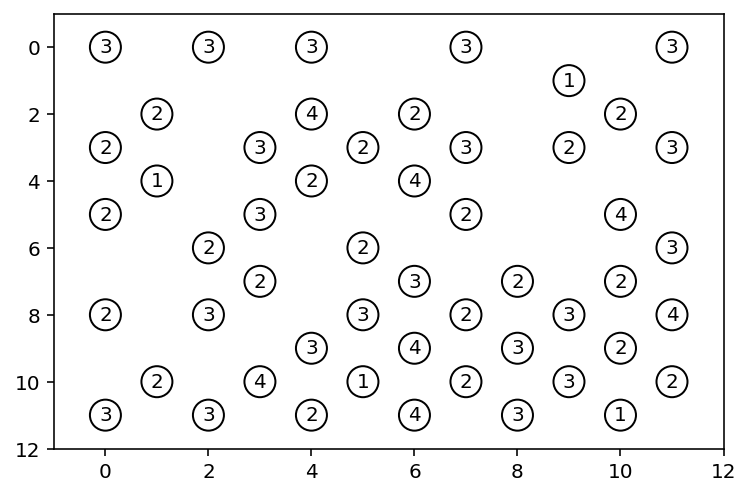

Done - ALL CONNECTED
finished:  0


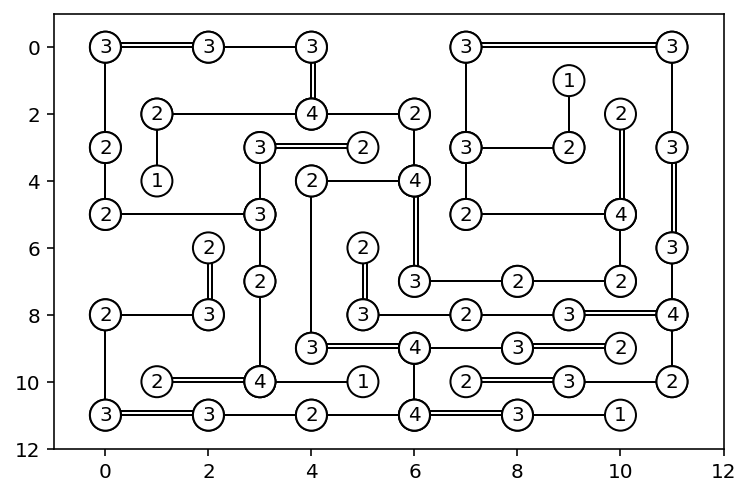

In [120]:
def main():
  global hashi, fname, rows, cols, lists
  x = input('Enter number of file hashi?.csv') 
  j = int(x)
  if j < 0:
    start, end = 2, abs(j) + 1
  else:
    start, end = j, j + 1
  for i in range(start, end):
    fname = f'{fname_}{i}'
    f_name = f'{fname}.xlsx'
    try:
      hashi = pd.read_excel(f_name, header=None)
    except:
      f_name = f'{fname}.csv'
      hashi = pd.read_csv(f_name, header=None)
    p(f_name)
    hashi.fillna(0, inplace=True)
    hashi = hashi.apply(pd.to_numeric, downcast='integer')
    rows = len(hashi)
    cols = len(hashi.columns)

    plot_table(hashi)
    for i in range(2,9):
      lists[i] = getPos(hashi, [i])

    solve_hashi(True)
    disp_to_file(df_sol, fname, '_solution')
  
main()  